In [4]:
import datetime
import numpy as np
from influxdb import InfluxDBClient

In [5]:
client = InfluxDBClient(host='140.112.42.158', port=8086, database='test_2')

In [6]:
CODE_TO_COUNTRY = {              # country language code to full language name  
        'zh-tw': 'Taiwan',
        'ko': 'Korean', 
        'ja': 'Japan',
        'es': 'Spanish',
        'fr': 'French',
        'ru': 'Russian',
        'west-us': 'West US',
        'US': 'United States',
        'SG': 'Singapore',
        'GB': 'Great Britain',
        'NL': 'Netherlands',
        'HK': 'Hong Kong'
    }

In [7]:
def build_query(t_s, t_e, channel=None, lang=None, loc=None):
    """
    gets all data from month/date to month/(date+1)
    t_s: time start
    t_e: time end 
    lang: stream language
    loc: client location 
    """
    channel = '/.*/' if channel is None else channel
    q = f"SELECT viewer, client_location, ip_list, fq_count, num_edge FROM {channel} WHERE time >= '{t_s}' AND time < '{t_e}'"
    if lang:
        q = f"{q} AND stream_language = '{lang}'"
    if loc:
        q = f"{q} AND client_location = '{loc}'"
    return q

def get_edge_num(result):
    tmp = list()
    transactions = 0
    for (stream, _), points in result.items():
        for point in points:
            edges = point['ip_list'].split(',')
            transactions += sum([int(fq) for fq in point['fq_count'].split(',')])
            for edge in edges:
                if edge not in tmp:
                    tmp.append(edge)
    return set(tmp), transactions

def mean(l):
    return sum(l)/len(l)

def TIMEFMT(t):
    return datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ')

#### Calculate gorund truth

In [13]:
START_T = '2019-11-01T10:00:00Z' # start time
END_T = '2019-11-01T11:00:00Z'   # end time
q = build_query(START_T, END_T, loc='west-eu')
result = client.query(q)

ground_truth, _ = get_edge_num(result) # total # of edge servers

In [14]:
START_T = '2019-11-01T10:00:00Z' # start time
END_T = '2019-11-01T11:00:00Z'   # end time
q = build_query(START_T, END_T, loc='west-eu')
result = client.query(q)

M, _ = get_edge_num(result) # number of edge servers in first capture

In [15]:
START_T = '2019-11-01T20:00:00Z' # start time
END_T = '2019-11-01T21:00:00Z'   # end time
q = build_query(START_T, END_T, loc='west-eu')
result = client.query(q)

C, _ = get_edge_num(result) # number of edge servers in second capture

#### Calculate intersection of edge servers between two captures 

In [16]:
R = M.intersection(C)
print(len(R))

125


#### Estimate total number of servers by CRC: $N=\dfrac{MC}{R}$

In [17]:
N = (len(M)*len(C))//len(R)
print(N)

358


#### Input whole week data 

In [18]:
def get_estimation(date, date_1, t1, t2, loc, lang):
    st = f'2019-11-{date}T00:00:00Z' 
    et = f'2019-11-{date_1}T00:00:00Z'
    m_st = f'2019-11-{date}T08:00:00Z'
    m_et = f'2019-11-{date}T{t1}Z'
    c_st = f'2019-11-{date}T16:00:00Z'
    c_et = f'2019-11-{date}T{t2}Z'
    
    q = build_query(st, et, loc=loc, lang=lang)
    result = client.query(q)
    gt, gt_t = get_edge_num(result) 
    
    q = build_query(m_st, m_et, loc=loc, lang=lang)
    result = client.query(q)
    M, M_t = get_edge_num(result) 
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    C, C_t = get_edge_num(result)
    
    R = M.intersection(C)
    
    try:
        N = len(M)*len(C)/len(R)
    except ZeroDivisionError:
        N = 0
    
    return int(N), len(gt), gt_t, (M_t+C_t)

In [19]:
date =   ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11']
date_1 = ['02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
time_1 = ['08:15:00', '08:30:00', '09:00:00', '10:00:00', '12:00:00', '14:00:00', '16:00:00']
time_2 = ['16:15:00', '16:30:00', '17:00:00', '18:00:00', '20:00:00', '22:00:00', '23:59:59']

In [20]:
gt = [141, 128, 152, 133, 140, 152, 128, 130, 131, 129, 116]
est = [[], [], [], [], [], [], []]
trans = [[], [], [], [], [], [], []]
error = []
error_daily = [[], [], [], [], [], [], []]

for i, (t1, t2) in enumerate(zip(time_1, time_2)):
    err = 0
    for d, d1 in zip(date, date_1):
        N, gt, gt_t, t = get_estimation(d, d1, t1, t2, 'west-eu', None)
        print(N, gt, t, gt_t)
        
        est[i].append(N)
        trans[i].append(t)
        
        err += (N-gt)**2
        error_daily[i].append(N-gt)
    err = (err/11)**(1/2)
    print(err)
    error.append(err)

279 566 6329 332171
776 589 5610 291484
170 680 5382 284945
190 607 5813 307217
397 653 5620 312219
318 584 4991 280142
245 599 5052 279455
672 601 4870 208486
309 534 4560 248266
13100 695 3977 257614
0 506 2028 83867
3753.890854227723
283 566 16309 332171
347 589 15787 291484
363 680 13935 284945
621 607 14080 307217
320 653 13853 312219
325 584 12927 280142
513 599 12198 279455
392 601 11816 208486
680 534 12363 248266
535 695 11541 257614
0 506 5477 83867
264.80473080091576
287 566 29882 332171
336 589 29800 291484
387 680 27417 284945
572 607 27806 307217
355 653 26632 312219
336 584 24504 280142
468 599 23501 279455
343 601 23149 208486
653 534 22978 248266
582 695 21845 257614
0 506 9988 83867
260.405802197612
370 566 59144 332171
349 589 59687 291484
440 680 58129 284945
461 607 55593 307217
367 653 56432 312219
508 584 50264 280142
456 599 48857 279455
438 601 48977 208486
445 534 48411 248266
511 695 47200 257614
0 506 12692 83867
234.97291913595646
393 566 115228 332171
476 

In [21]:
# import plotting related libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches

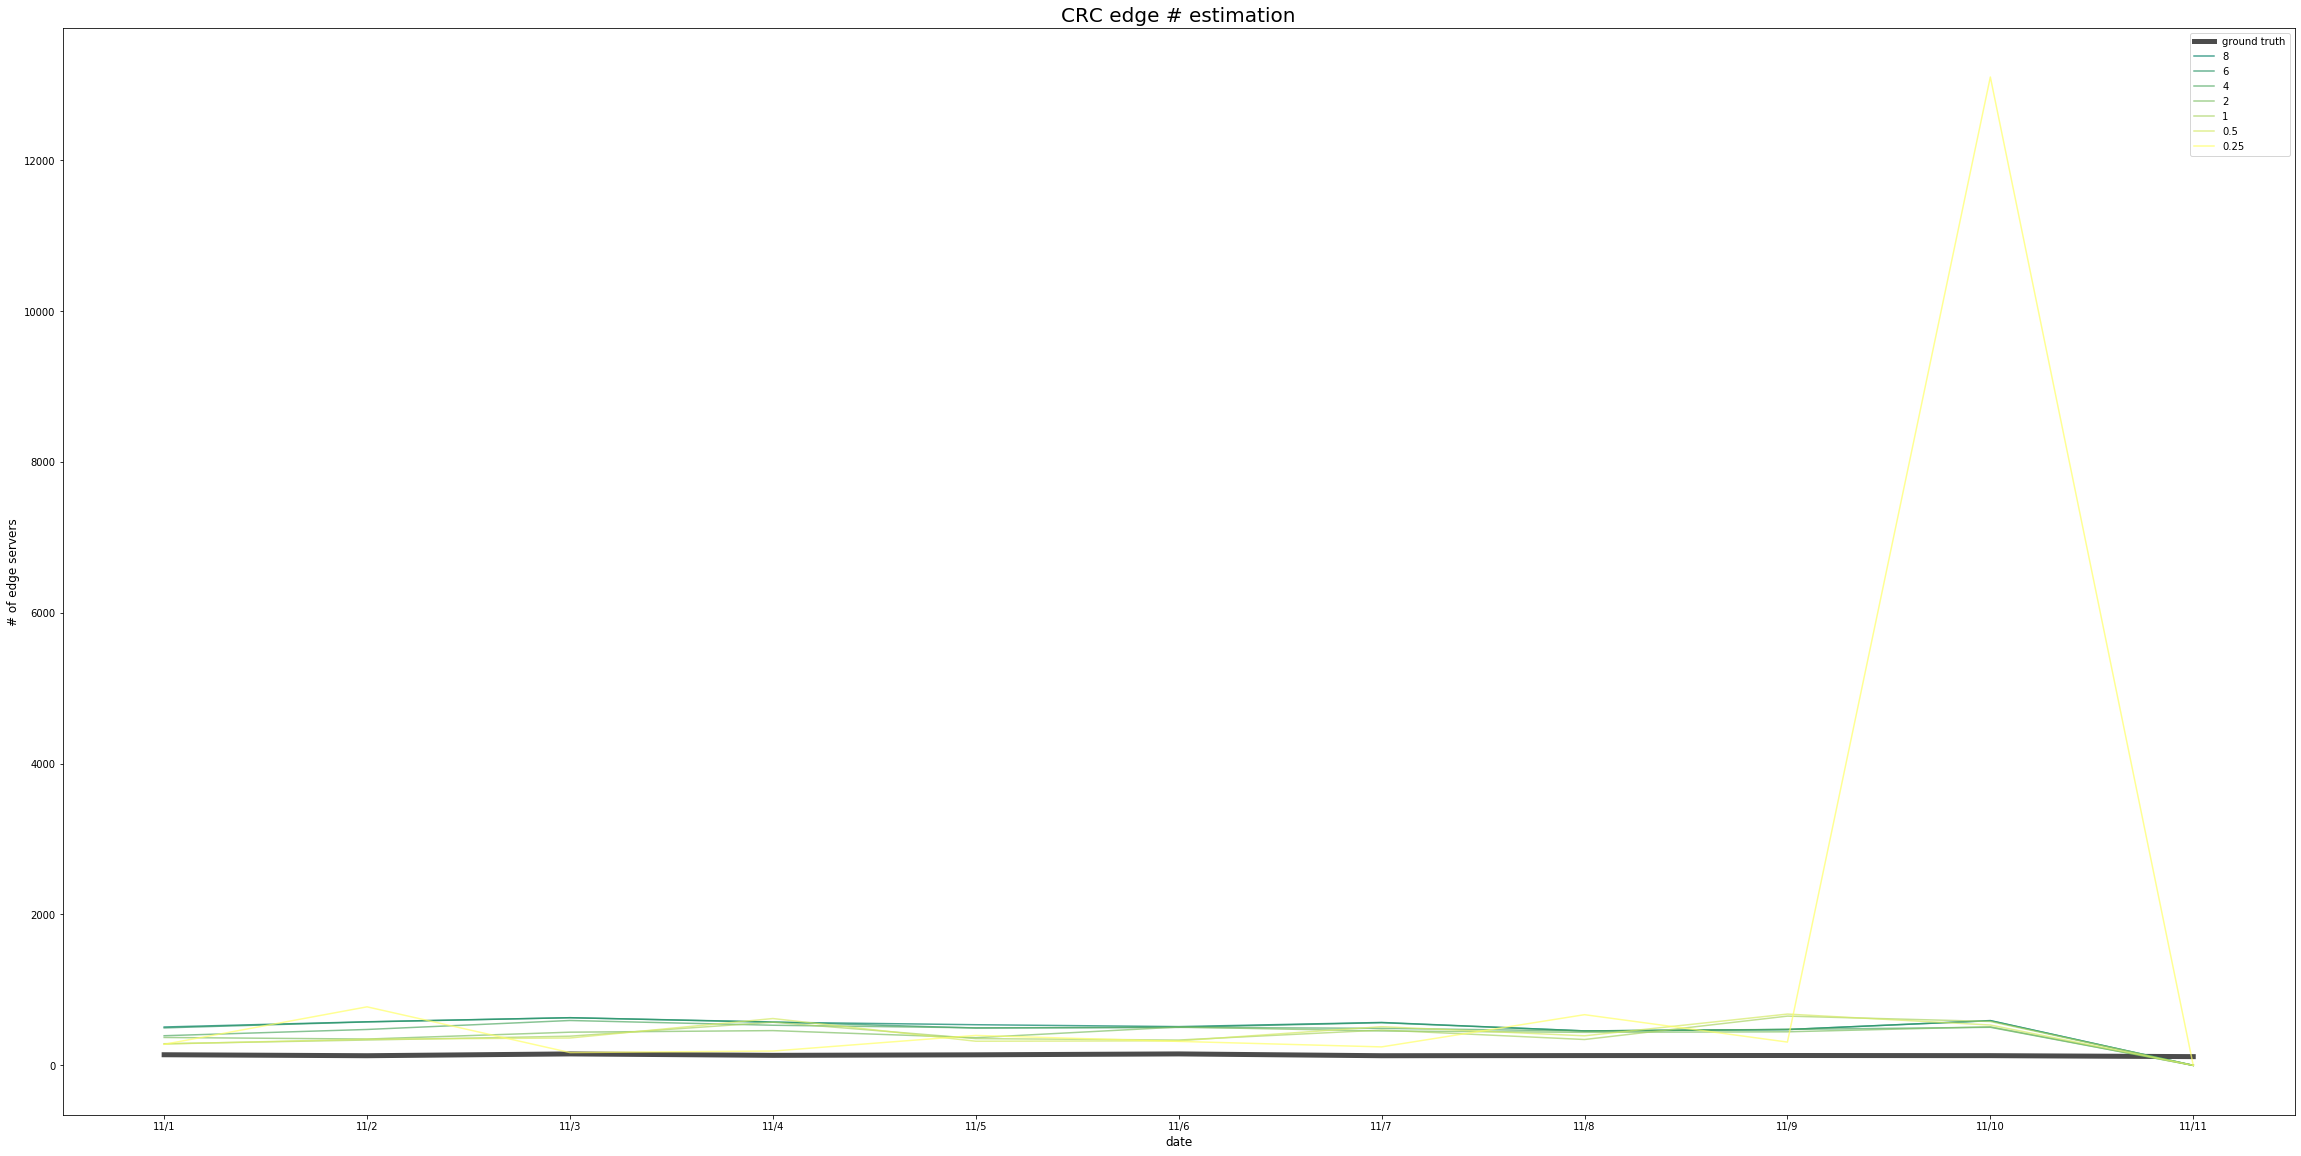

In [22]:
gt = [141, 128, 152, 133, 140, 152, 128, 130, 131, 129, 116]
fig, ax = plt.subplots(figsize=(40, 20))
# x_axis = list(range(len(gt)))
x_axis = ['11/1','11/2', '11/3', '11/4', '11/5', '11/6', '11/7', '11/8', '11/9', '11/10', '11/11']
labels = ['8', '6', '4', '2', '1', '0.5', '0.25']
ax.set_xlabel('date', fontsize=12)
ax.set_ylabel('# of edge servers', fontsize=12)

color_idx = np.linspace(0, 1, 7)
plt.plot(x_axis, gt, linewidth=5, color='black', label='ground truth', alpha=0.7)
for i, (c, e) in enumerate(zip(color_idx, est[::-1])):
    plt.plot(x_axis, e, color=plt.cm.summer(c), label=labels[i], alpha=0.7)
    
plt.title('CRC edge # estimation', fontsize=20)
plt.legend()
plt.show()


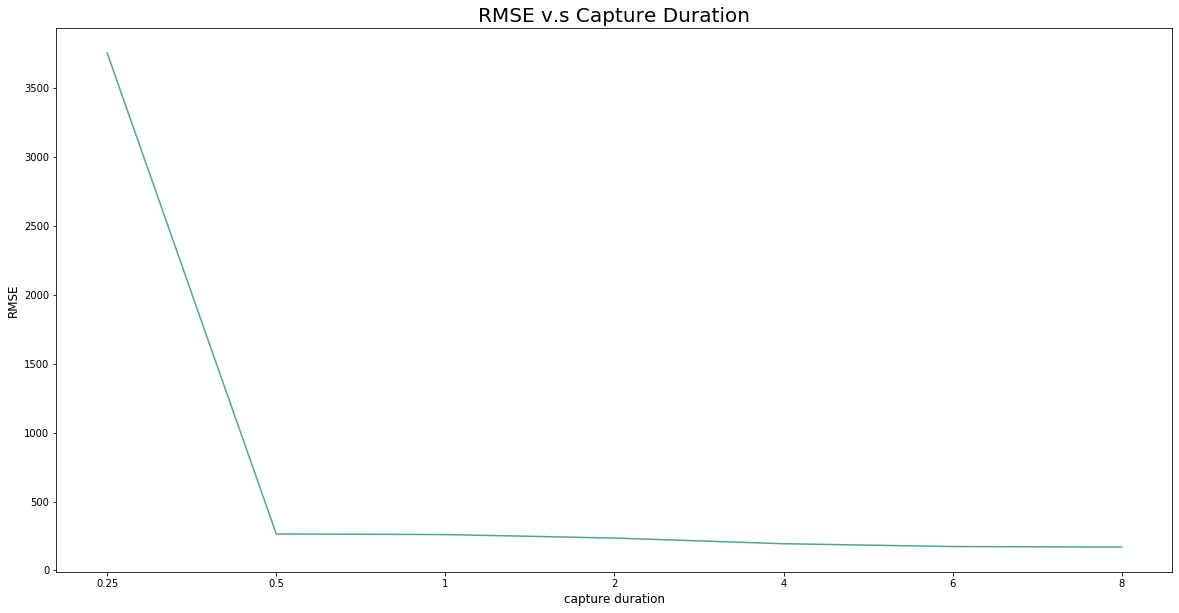

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['0.25', '0.5', '1', '2', '4', '6', '8']

ax.set_xlabel('capture duration', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)

color_idx = np.linspace(0, 1, 7)
plt.plot(x_axis, error, color=plt.cm.summer(1), alpha=0.7)
plt.title('RMSE v.s Capture Duration', fontsize=20)

plt.show()

#### TODO: Plot # of reduction in transactions

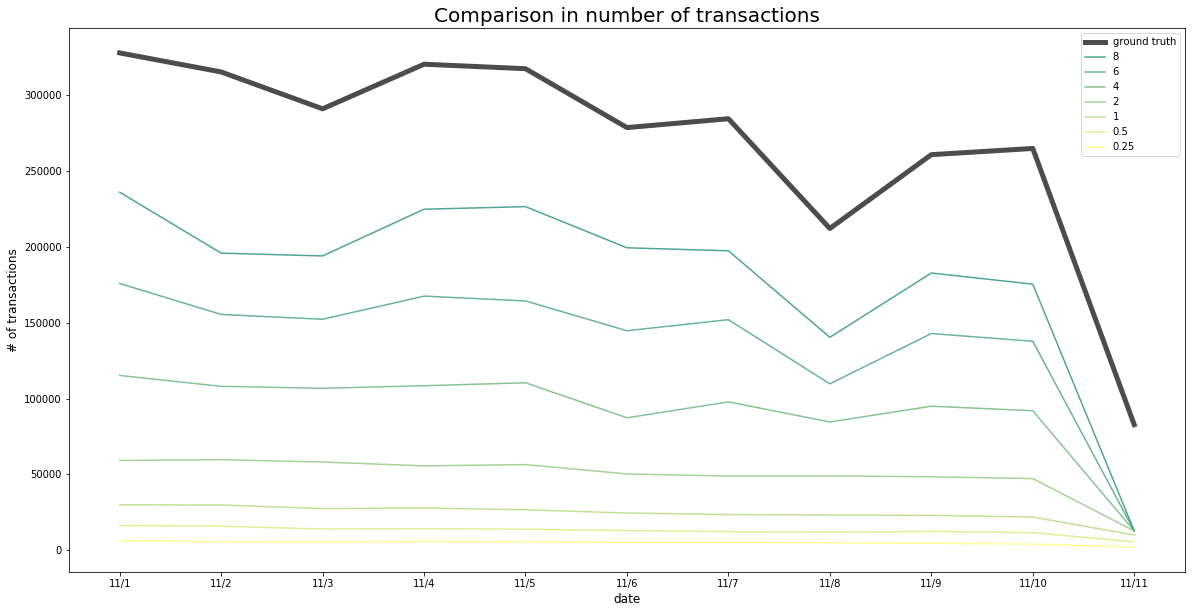

In [24]:
trans_gt = [327913, 315358, 291054, 320451, 317502, 278662, 284515, 212132, 260809, 264912, 82769]
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['11/1','11/2', '11/3', '11/4', '11/5', '11/6', '11/7', '11/8', '11/9', '11/10', '11/11']
labels = ['8', '6', '4', '2', '1', '0.5', '0.25']
ax.set_xlabel('date', fontsize=12)
ax.set_ylabel('# of transactions', fontsize=12)

color_idx = np.linspace(0, 1, 7)
plt.plot(x_axis, trans_gt, linewidth=5, color='black', label='ground truth', alpha=0.7)
for i, (c, e) in enumerate(zip(color_idx, trans[::-1])):
    plt.plot(x_axis, e, color=plt.cm.summer(c), label=labels[i], alpha=0.7)
    
plt.title('Comparison in number of transactions', fontsize=20)
plt.legend()
plt.show()

In [25]:
trans_date = list(zip(*trans))
per = [[round(t/gt, 3) for t in td] for (gt, td) in zip(trans_gt, trans_date)]
per = list(zip(*per)) 
print(per)

[(0.019, 0.018, 0.018, 0.018, 0.018, 0.018, 0.018, 0.023, 0.017, 0.015, 0.025), (0.05, 0.05, 0.048, 0.044, 0.044, 0.046, 0.043, 0.056, 0.047, 0.044, 0.066), (0.091, 0.094, 0.094, 0.087, 0.084, 0.088, 0.083, 0.109, 0.088, 0.082, 0.121), (0.18, 0.189, 0.2, 0.173, 0.178, 0.18, 0.172, 0.231, 0.186, 0.178, 0.153), (0.351, 0.343, 0.367, 0.338, 0.348, 0.313, 0.344, 0.398, 0.364, 0.347, 0.153), (0.536, 0.493, 0.523, 0.523, 0.518, 0.519, 0.534, 0.517, 0.548, 0.52, 0.153), (0.72, 0.621, 0.667, 0.702, 0.714, 0.716, 0.694, 0.662, 0.701, 0.662, 0.153)]


#### Box plot of *error rate* and *reduction percentage*

In [26]:
error_daily = [tuple([abs(e)for e in err]) for err in error_daily]
print(gt)
error_daily_per = [[e/gt[i] for i, e in enumerate(err)] for err in error_daily]

[141, 128, 152, 133, 140, 152, 128, 130, 131, 129, 116]


In [27]:
print(per)
print(error_daily)
print(error_daily_per)

[(0.019, 0.018, 0.018, 0.018, 0.018, 0.018, 0.018, 0.023, 0.017, 0.015, 0.025), (0.05, 0.05, 0.048, 0.044, 0.044, 0.046, 0.043, 0.056, 0.047, 0.044, 0.066), (0.091, 0.094, 0.094, 0.087, 0.084, 0.088, 0.083, 0.109, 0.088, 0.082, 0.121), (0.18, 0.189, 0.2, 0.173, 0.178, 0.18, 0.172, 0.231, 0.186, 0.178, 0.153), (0.351, 0.343, 0.367, 0.338, 0.348, 0.313, 0.344, 0.398, 0.364, 0.347, 0.153), (0.536, 0.493, 0.523, 0.523, 0.518, 0.519, 0.534, 0.517, 0.548, 0.52, 0.153), (0.72, 0.621, 0.667, 0.702, 0.714, 0.716, 0.694, 0.662, 0.701, 0.662, 0.153)]
[(287, 187, 510, 417, 256, 266, 354, 71, 225, 12405, 506), (283, 242, 317, 14, 333, 259, 86, 209, 146, 160, 506), (279, 253, 293, 35, 298, 248, 131, 258, 119, 113, 506), (196, 240, 240, 146, 286, 76, 143, 163, 89, 184, 506), (173, 113, 85, 75, 155, 80, 108, 145, 57, 190, 506), (69, 13, 48, 32, 158, 79, 33, 144, 59, 103, 506), (57, 11, 48, 35, 114, 70, 30, 144, 59, 101, 506)]
[[2.0354609929078014, 1.4609375, 3.3552631578947367, 3.1353383458646618, 1.8

In [28]:
per_mean = [100*mean(l) for l in per]
error_daily_mean = [mean(l) for l in error_daily]
error_daily_per_mean = [100*mean(l) for l in error_daily_per]

print(per_mean)
print(error_daily_mean)
print(error_daily_per_mean)

[1.8818181818181818, 4.890909090909091, 9.281818181818181, 18.36363636363636, 33.32727272727273, 48.945454545454545, 63.745454545454535]
[1407.6363636363637, 232.27272727272728, 230.27272727272728, 206.27272727272728, 153.36363636363637, 113.0909090909091, 106.81818181818181]
[1082.9069744226595, 174.2497785161916, 173.27921402568137, 157.48607559685502, 119.05025548864785, 88.83662286590838, 84.37650824252859]


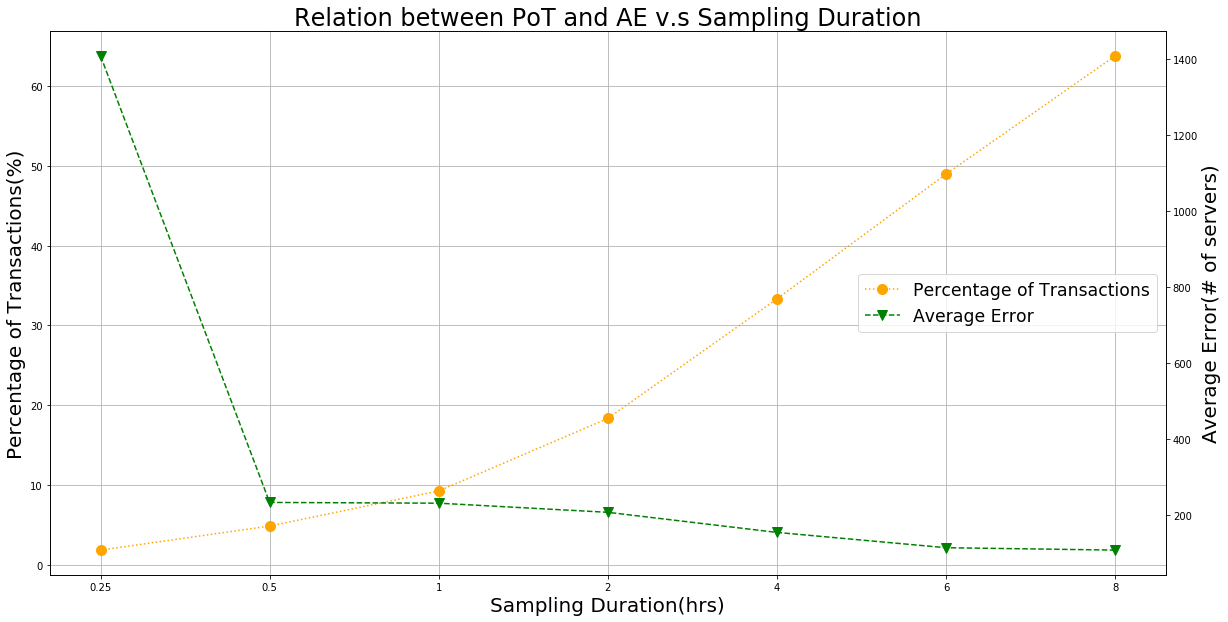

In [29]:
fig, ax1 = plt.subplots(figsize=(20, 10))
labels = ['0.25', '0.5', '1', '2', '4', '6', '8']

# mirror axis 
ax2 = ax1.twinx()

ln1 = ax1.plot(labels, per_mean, label='Percentage of Transactions', linestyle=':', color='orange', marker='o', markersize=10)
ln2 = ax2.plot(labels, error_daily_mean, label='Average Error', linestyle='--', color='green', marker='v', markersize=10)

# make labels appear in one legend
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right', fontsize = 'xx-large')

ax2.set_ylabel('Average Error(# of servers)', fontsize=20)
ax1.set_ylabel('Percentage of Transactions(%)', fontsize=20)
ax1.set_xlabel('Sampling Duration(hrs)', fontsize=20)
ax1.set_title('Relation between PoT and AE v.s Sampling Duration', fontsize=24)

ax1.grid()
plt.show()

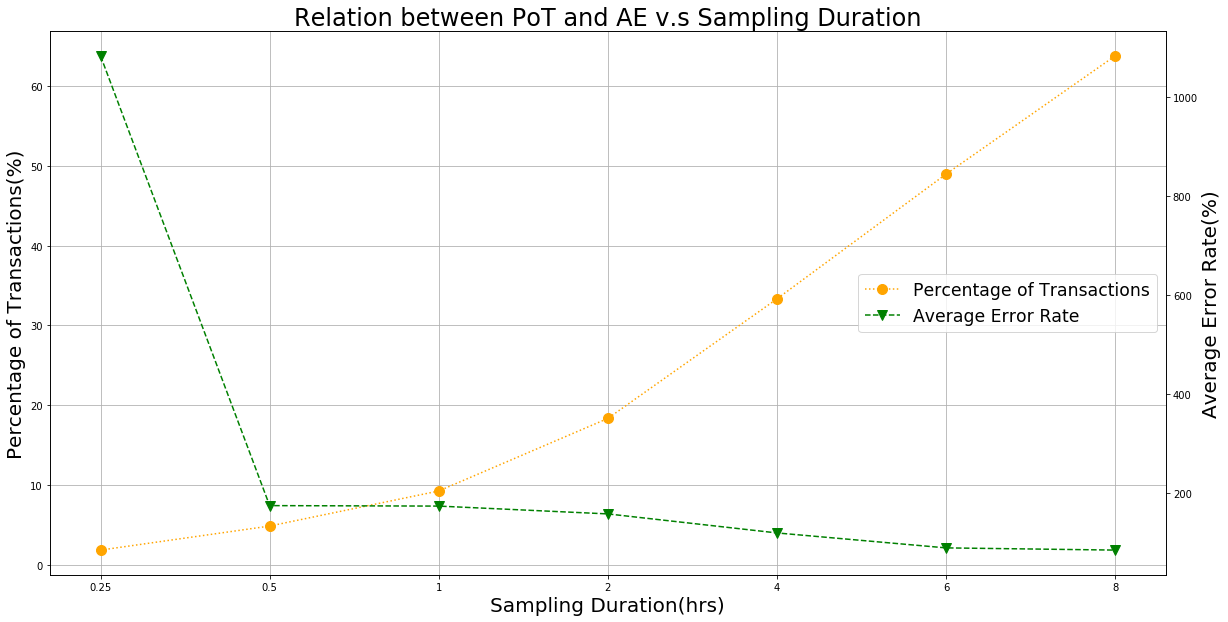

In [30]:
fig, ax1 = plt.subplots(figsize=(20, 10))
labels = ['0.25', '0.5', '1', '2', '4', '6', '8']

# mirror axis 
ax2 = ax1.twinx()

ln1 = ax1.plot(labels, per_mean, label='Percentage of Transactions', linestyle=':', color='orange', marker='o', markersize=10)
ln2 = ax2.plot(labels, error_daily_per_mean, label='Average Error Rate', linestyle='--', color='green', marker='v', markersize=10)

# make labels appear in one legend
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center right', fontsize = 'xx-large')

ax2.set_ylabel('Average Error Rate(%)', fontsize=20)
ax1.set_ylabel('Percentage of Transactions(%)', fontsize=20)
ax1.set_xlabel('Sampling Duration(hrs)', fontsize=20)
ax1.set_title('Relation between PoT and AE v.s Sampling Duration', fontsize=24)

ax1.grid()
plt.show()

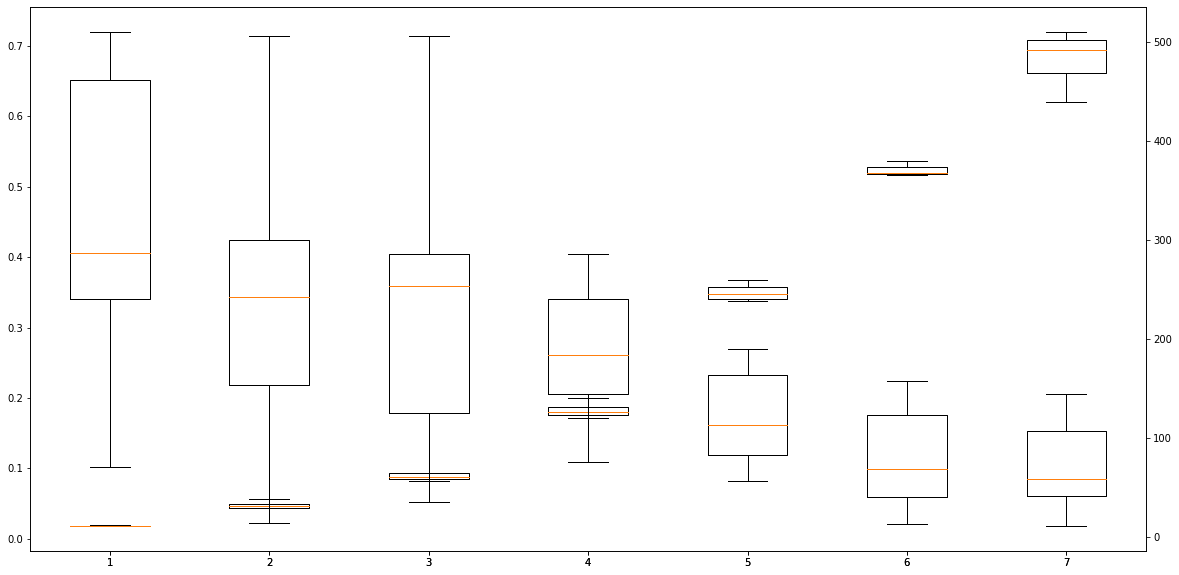

In [31]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

ax1.boxplot(per, 0, '')
ax2.boxplot(error_daily, 0, '')


plt.show()